In [49]:
# Import relevant libraries
import sqlite3
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

# for better resolution plots
%config InlineBackend.figure_format = 'retina' # optionally, you can change 'svg' to 'retina'

# Setting seaborn style
sns.set()

In [50]:
# Get the dataset and checking its first rows
df_train = pd.read_excel(r'Train.xlsx')
df_train.head()

,CITIZEN_ID,Name,Birthday,Native Continent,Marital Status,Lives with,Base Area,Education Level,Years of Education,Employment Sector,Role,Working Hours per week,Money Received,Ticket Price,Income
0,12486,Mr. Adam Glover,"July 1,2003",Europe,Married,Wife,Northbury,High School + PostGraduation,13,Private Sector - Services,Repair & constructions,40,0,2273,1
1,12487,Mr. Cameron McDonald,"January 25,2006",Europe,Married,Wife,Northbury,Professional School,12,Public Sector - Others,Repair & constructions,40,0,0,1
2,12488,Mr. Keith Davidson,"May 10,2009",Europe,Married,Wife,Northbury,Professional School,12,Private Sector - Services,Sales,46,0,2321,1
3,12489,Mr. Alexander Gill,"March 25,1985",Europe,Married,Wife,Northbury,High School - 2nd Cycle,11,Private Sector - Services,Security,37,5395,0,1
4,12490,Mr. Neil Piper,"May 29,2015",Europe,Single,Other Family,Northbury,PhD,21,Self-Employed (Individual),Professor,45,0,0,1


## Data Exploration

In [51]:
# Checking data types and nulls in the dataset --> see there are no nulls
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22400 entries, 0 to 22399
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CITIZEN_ID              22400 non-null  int64 
 1   Name                    22400 non-null  object
 2   Birthday                22400 non-null  object
 3   Native Continent        22400 non-null  object
 4   Marital Status          22400 non-null  object
 5   Lives with              22400 non-null  object
 6   Base Area               22400 non-null  object
 7   Education Level         22400 non-null  object
 8   Years of Education      22400 non-null  int64 
 9   Employment Sector       22400 non-null  object
 10  Role                    22400 non-null  object
 11  Working Hours per week  22400 non-null  int64 
 12  Money Received          22400 non-null  int64 
 13  Ticket Price            22400 non-null  int64 
 14  Income                  22400 non-null  int64 
dtypes:

In [52]:
# Birthday is type object, so we're transforming it to type datetime
# For that we must first fix the problem of having February 29 for non-leap years --> turn all February 29 to February 28
from datetime import datetime

df_train['Birthday']=df_train['Birthday'].map(lambda x: x.replace("February 29", "February 28"))

# Check if the replacement worked
df_train['Birthday'][df_train['Birthday'].str.contains("February 29")]

Series([], Name: Birthday, dtype: object)

In [53]:
# Change the format the date appears and the data type to datetime
df_train['Birthday']=df_train['Birthday'].map(lambda x: datetime.strptime(x, " %B %d,%Y").date())
df_train['Birthday'] = pd.to_datetime(df_train['Birthday'])

In [54]:
# Get a descriptive overview of the variables (both numeric and categorical)
df_train.describe(include="all")

,CITIZEN_ID,Name,Birthday,Native Continent,Marital Status,Lives with,Base Area,Education Level,Years of Education,Employment Sector,Role,Working Hours per week,Money Received,Ticket Price,Income
count,22400.000000,22400,22400,22400,22400,22400,22400,22400,22400.000000,22400,22400,22400.000000,22400.000000,22400.000000,22400.000000
unique,NaN,16074,11229,5,7,6,40,16,NaN,9,15,NaN,NaN,NaN,NaN
top,NaN,Mr. Connor Blake,2025-08-15 00:00:00,Europe,Married,Wife,Northbury,Professional School,NaN,Private Sector - Services,Professor,NaN,NaN,NaN,NaN
freq,NaN,4,9,19111,10219,9012,20074,7232,NaN,15599,2849,NaN,NaN,NaN,NaN
first,NaN,NaN,1958-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2031-10-11 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,23685.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.173884,NaN,NaN,40.483795,1324.915357,109.145313,0.237098
std,6466.467351,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.512451,NaN,NaN,12.370921,9227.771813,500.208904,0.425313
min,12486.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,1.000000,0.000000,0.000000,0.000000
25%,18085.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.000000,NaN,NaN,40.000000,0.000000,0.000000,0.000000


In [55]:
# Define Citizen_ID as the index
df_train.set_index("CITIZEN_ID", inplace=True)

# Define Income variable as the target and remove it from the dataframe with the independent variables
target = df_train['Income']
df_train = df_train.drop(['Income'], axis=1)

# Define metric and non-metric datasets
metric= df_train.loc[:, np.array(df_train.dtypes=="int64")]
non_metric= df_train.loc[:,np.array(df_train.dtypes=="object")]

In [56]:
# Get only the year from Birthday, so as to get a better visualization of the values
metric['Birthday']=df_train.Birthday.map(lambda x: x.year)

# Remove Name from the list of non_metric variables since that gives us no meaning or valuable information and plotting it would be useless
non_metric.drop(columns="Name", inplace=True)

<ipython-input-56-86cd2c956a35>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metric['Birthday']=df_train.Birthday.map(lambda x: x.year)
/Users/Mariana/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


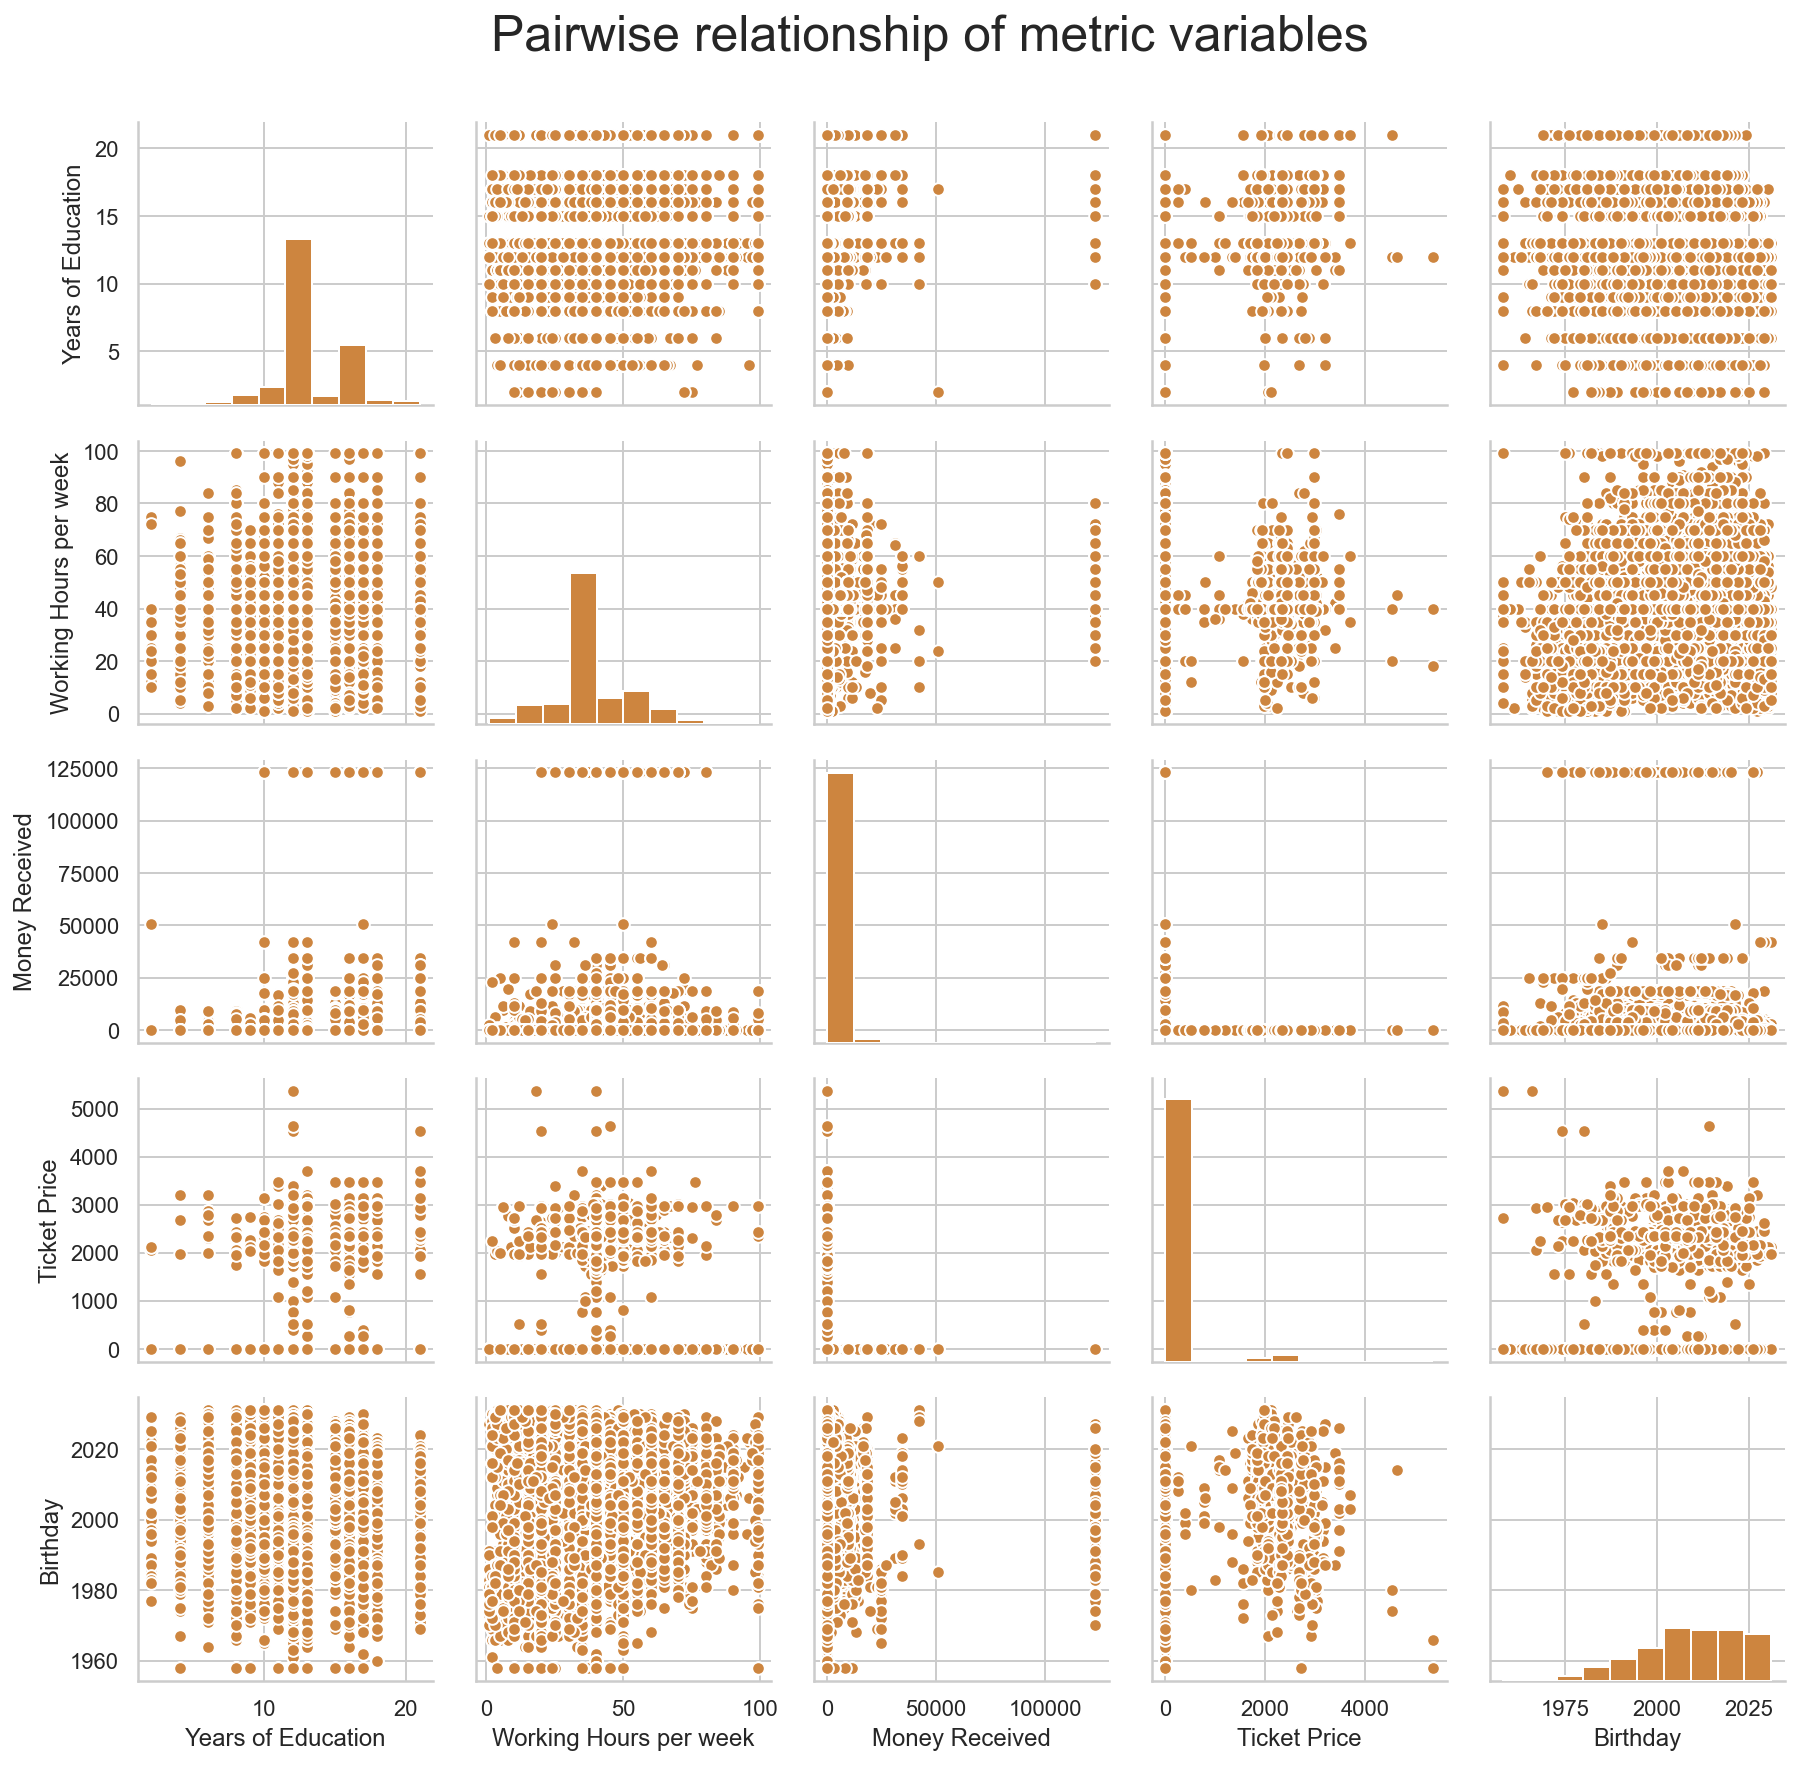

In [57]:
# Checking metrics variables' distribution and pairwise relationship
sns.set(style="whitegrid")

# Setting pairgrid
g = sns.PairGrid(metric)

# Populating pairgrid
mdg = g.map_diag(plt.hist, edgecolor="w", color="peru")
mog = g.map_offdiag(plt.scatter, edgecolor="w", color="peru", s=40)
    
# Layout
plt.subplots_adjust(top=0.92)
plt.suptitle("Pairwise relationship of metric variables", fontsize=25)

plt.show()

/Users/Mariana/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/Mariana/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/Mariana/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warn

Text(0.5, 0.98, 'Distribution of non-metric variables')

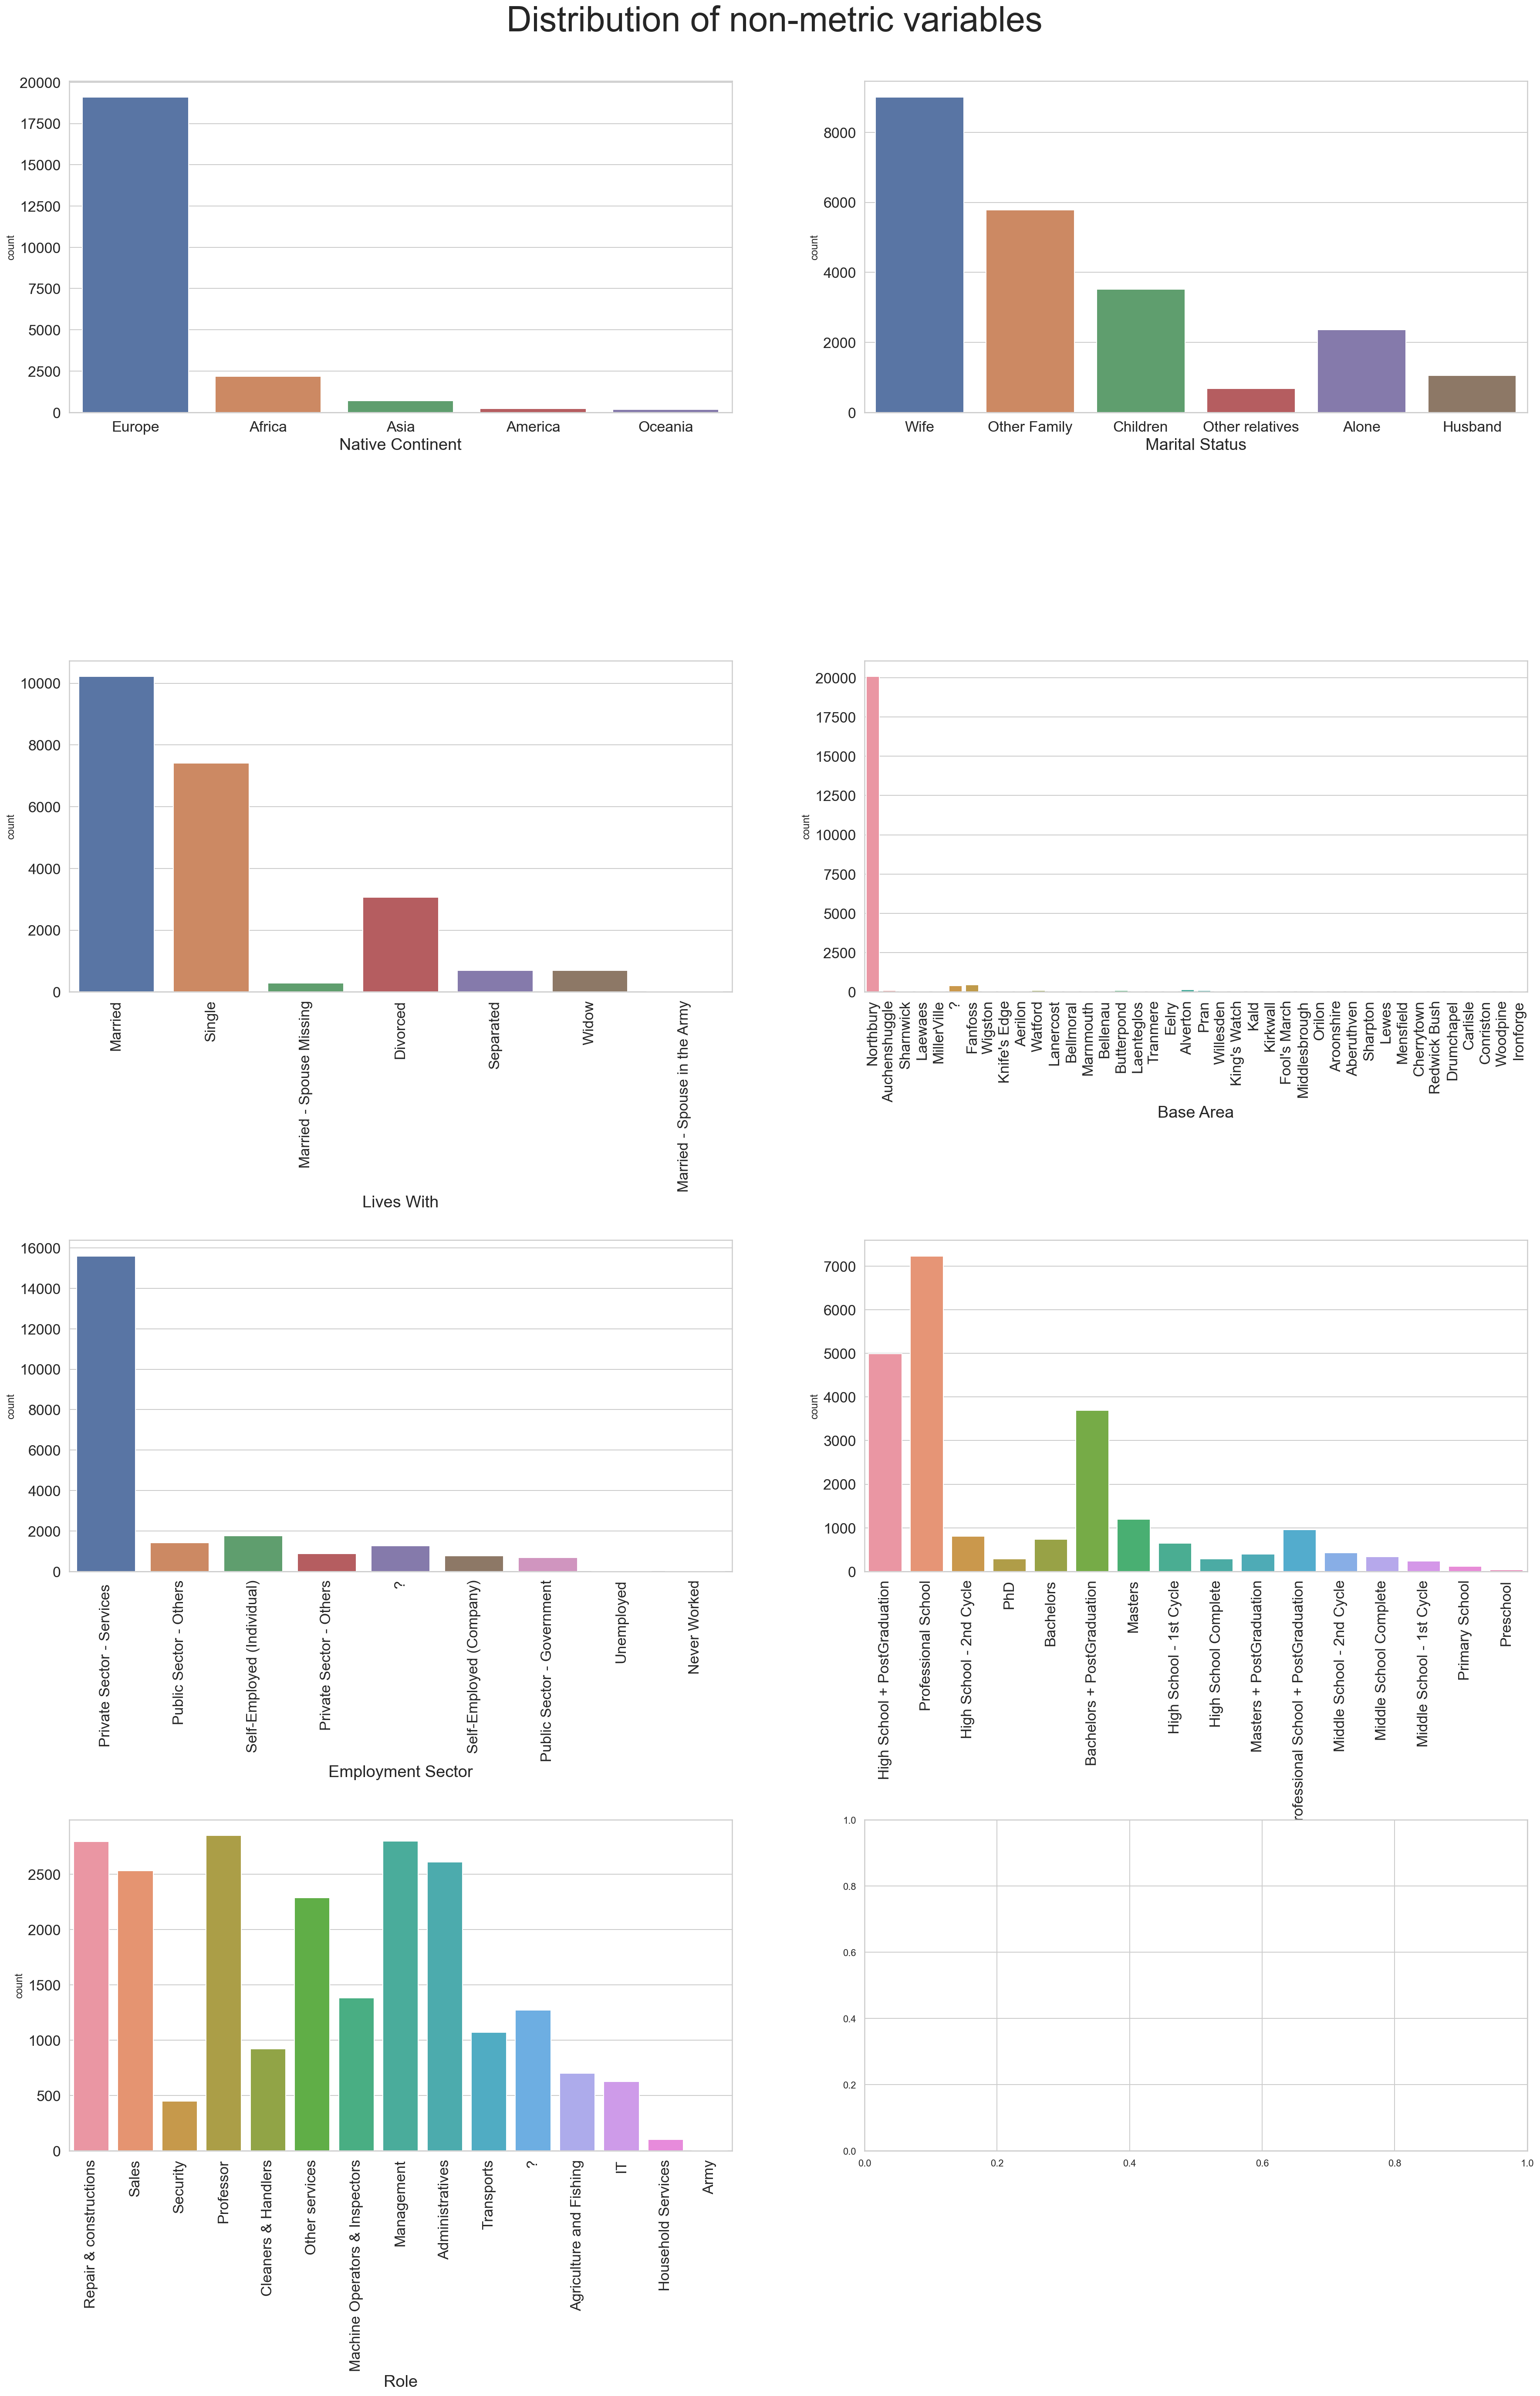

In [58]:
# Funciona
sns.set_style("whitegrid")
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(30,40))

ax1=sns.countplot(non_metric["Native Continent"], ax=axes[0,0])
ax2=sns.countplot(non_metric["Lives with"], ax=axes[0,1])
ax3=sns.countplot(non_metric["Marital Status"], ax=axes[1,0])
ax4=sns.countplot(non_metric["Base Area"], ax=axes[1,1])
ax5=sns.countplot(non_metric["Employment Sector"], ax=axes[2,0])
ax6=sns.countplot(non_metric["Education Level"], ax=axes[2,1])
ax7=sns.countplot(non_metric["Role"], ax=axes[3,0])
# ax8=sns.countplot(non_metric["Birthday"], ax=axes[3,1])

ax1.tick_params(labelsize=17)
ax1.set_xlabel(xlabel='Native Continent',fontsize = 19)

ax2.tick_params(labelsize=17)
ax2.set_xlabel(xlabel='Marital Status',fontsize = 19)

ax3.tick_params(labelsize=17)
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=90)
ax3.set_xlabel(xlabel='Lives With',fontsize = 19)

ax4.tick_params(labelsize=17)
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=90)
ax4.set_xlabel(xlabel='Base Area',fontsize = 19)

ax5.tick_params(labelsize=17)
ax5.set_xticklabels(ax5.get_xticklabels(), rotation=90)
ax5.set_xlabel(xlabel='Employment Sector',fontsize = 19)

ax6.tick_params(labelsize=17)
ax6.set_xticklabels(ax6.get_xticklabels(), rotation=90)
ax6.set_xlabel(xlabel='Education Level',fontsize = 19)

ax7.tick_params(labelsize=17)
ax7.set_xticklabels(ax7.get_xticklabels(), rotation=90)
ax7.set_xlabel(xlabel='Role',fontsize = 19)

# ax8.tick_params(labelsize=17)
# ax8.set_xticklabels(ax.get_xticklabels(), rotation=90)
# ax8.set_xlabel(xlabel='Birthday',fontsize = 19)

plt.subplots_adjust(top=0.95,hspace=0.75)
plt.suptitle("Distribution of non-metric variables", fontsize=40)

In [59]:
# Looking at the plots above, we can see the distribution of the values per category, for each categorical variables.
# With this, we see that there are 3 variables containing "?" as a value, which we understand are be null values
# So, here we are replacing those ? for null values, to analyze them more efficiently
df_train=df_train.replace('?', np.nan)

In [60]:
# Now we can already see how many missing values each variable has
df_train.isna().sum()

Name                         0
Birthday                     0
Native Continent             0
Marital Status               0
Lives with                   0
Base Area                  395
Education Level              0
Years of Education           0
Employment Sector         1264
Role                      1271
Working Hours per week       0
Money Received               0
Ticket Price                 0
dtype: int64

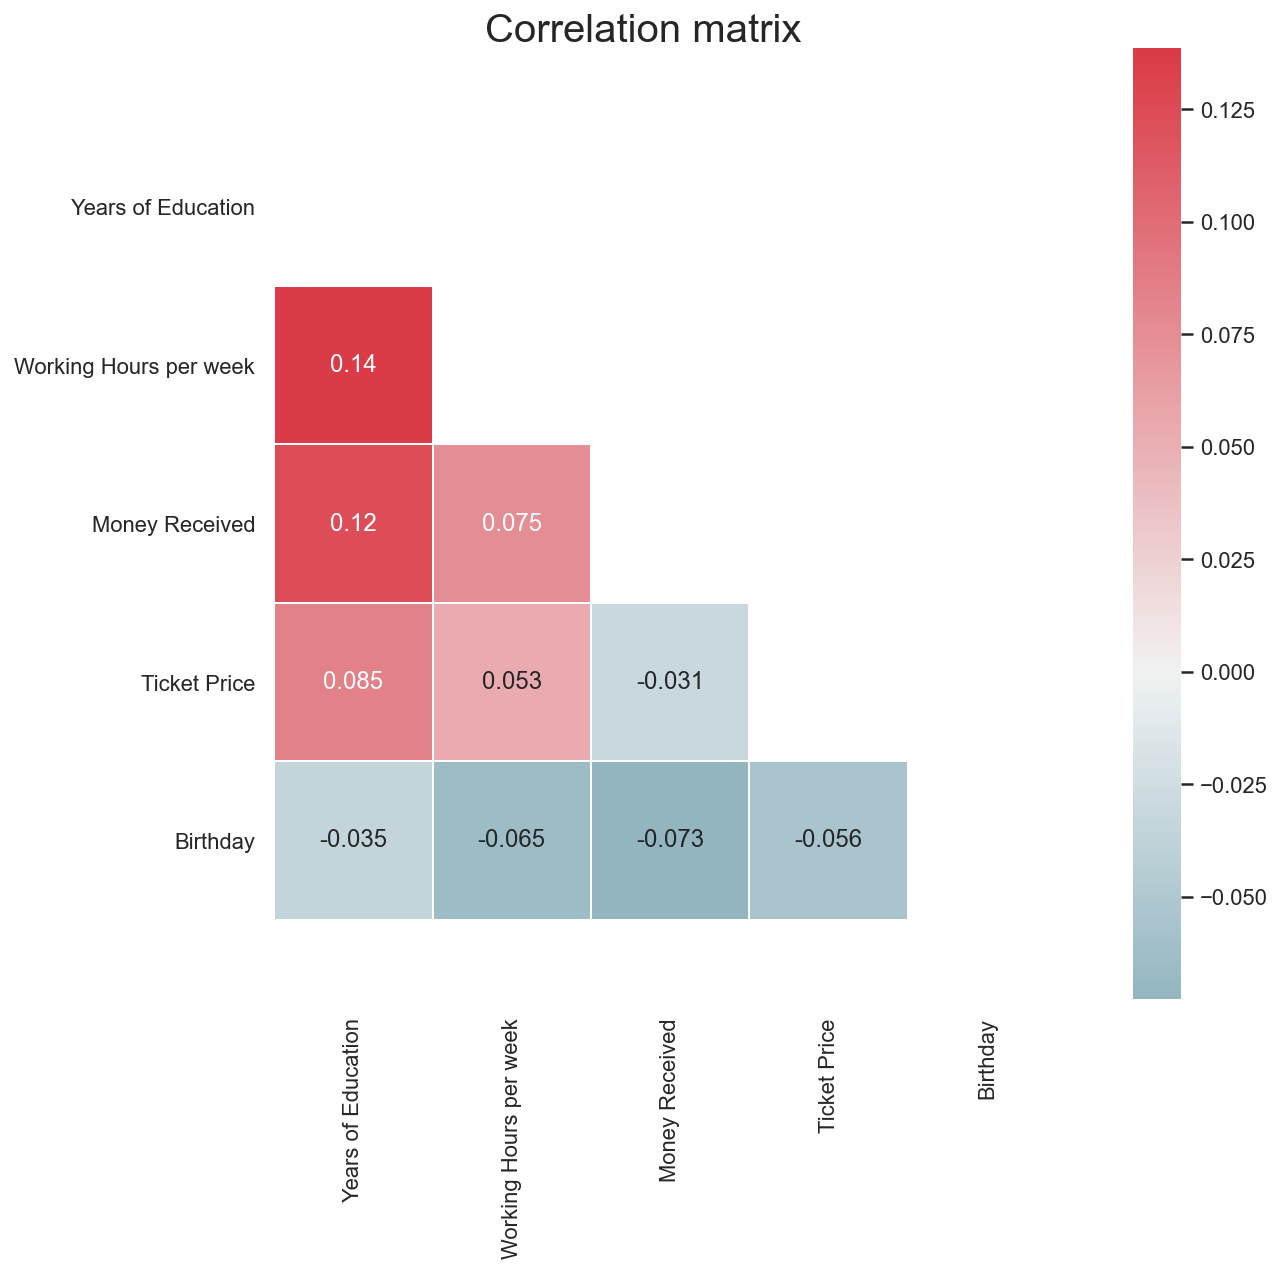

In [61]:
#inutil mas func
sns.set(style="white")

# Compute the correlation matrix
corr = metric.corr() #Getting correlation of numerical variables

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool) #Return an array of zeros (Falses) with the same shape and type as a given array
mask[np.triu_indices_from(mask)] = True #The upper-triangle array is now composed by True values

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(12, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True) #Make a diverging palette between two HUSL colors. Return a matplotlib colormap object.

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, ax=ax, annot=True)

# Layout
plt.subplots_adjust(top=0.95)
plt.suptitle("Correlation matrix", fontsize=20)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
# Fixing the bug of partially cut-off bottom and top cells
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

plt.show()

In [62]:
pd.set_option('display.max_rows', 500)
df_train.groupby(["Base Area","Role"])["Role"].count()

Base Area      Role                          
Aberuthven     Administratives                      5
               Cleaners & Handlers                  3
               Household Services                   1
               IT                                   1
               Machine Operators & Inspectors       4
               Other services                       2
               Professor                            1
               Repair & constructions               4
               Sales                                2
Aerilon        Administratives                      2
               Agriculture and Fishing              1
               Cleaners & Handlers                  6
               Household Services                   1
               IT                                   2
               Machine Operators & Inspectors       6
               Management                           3
               Other services                       1
               Professor            

In [63]:
pd.crosstab(df_train['Base Area'], df_train['Role'],  margins = True)

Role,Administratives,Agriculture and Fishing,Army,Cleaners & Handlers,Household Services,IT,Machine Operators & Inspectors,Management,Other services,Professor,Repair & constructions,Sales,Security,Transports,All
Base Area,,,,,,,,,,,,,,,
Aberuthven,5,0,0,3,1,1,4,0,2,1,4,2,0,0,23
Aerilon,2,1,0,6,1,2,6,3,1,6,9,3,0,3,43
Alverton,28,3,0,4,1,9,10,9,22,19,6,13,2,1,127
Aroonshire,7,1,0,3,1,0,6,14,8,7,4,6,0,6,63
Auchenshuggle,3,2,0,7,5,0,4,2,29,4,14,5,0,3,78
Bellenau,0,0,0,0,0,0,2,3,0,2,0,0,1,0,8
Bellmoral,6,0,0,2,1,1,6,2,5,3,8,2,0,2,38
Butterpond,14,0,0,4,0,1,5,12,3,26,9,9,4,3,90
Carlisle,4,0,0,0,0,2,2,1,3,1,2,1,0,1,17


In [64]:
pd.crosstab(df_train['Marital Status'], df_train['Lives with'], margins=True)

Lives with,Alone,Children,Husband,Other Family,Other relatives,Wife,All
Marital Status,,,,,,,
Divorced,1113,227,0,1657,75,0,3072
Married,0,73,1042,12,85,9007,10219
Married - Spouse Missing,85,33,0,141,25,0,284
Married - Spouse in the Army,0,1,7,0,1,5,14
Separated,302,69,0,289,39,0,699
Single,607,3106,0,3281,422,0,7416
Widow,255,10,0,397,34,0,696
All,2362,3519,1049,5777,681,9012,22400


## Coherence Checks

In [173]:
#MUDAR
#Check if there is someone with more than 70 years that has Employment Sector not null
df_train[(metric.Birthday<1978)]
#& (metric["Money Received"]==0)] that did not receive money to go

,Name,Birthday,Native Continent,Marital Status,Lives with,Base Area,Education Level,Years of Education,Employment Sector,Role,Working Hours per week,Money Received,Ticket Price
CITIZEN_ID,,,,,,,,,,,,,
12530,Mrs. Carolyn Tucker,1976-02-03,Europe,Widow,Other Family,Northbury,High School - 2nd Cycle,11,NaN,NaN,24,0,0
12535,Mr. Evan Young,1975-02-13,Europe,Married,Wife,Aerilon,Masters,17,Public Sector - Others,Professor,10,0,0
12556,Mr. Jason MacLeod,1975-05-06,Europe,Married,Wife,Northbury,High School - 2nd Cycle,11,NaN,NaN,8,0,0
12633,Mr. Brandon Henderson,1969-03-29,Europe,Married,Wife,Northbury,Bachelors + PostGraduation,16,Self-Employed (Company),Sales,20,0,0
12641,Mr. Joe Simpson,1974-08-10,Europe,Divorced,Other relatives,Northbury,Masters + PostGraduation,18,Self-Employed (Individual),Professor,40,0,0
12706,Mr. Joe Morrison,1972-08-25,Europe,Widow,Other Family,Northbury,Middle School Complete,9,NaN,NaN,25,0,0
12738,Mr. Andrew Grant,1977-02-13,Europe,Married,Wife,Northbury,Bachelors + PostGraduation,16,Self-Employed (Company),Management,60,0,2942
12739,Mr. Christian Knox,1965-08-08,Europe,Divorced,Other Family,Northbury,Professional School,12,Self-Employed (Company),Sales,20,0,0
12783,Mr. Nathan Skinner,1958-03-14,Europe,Married,Wife,Willesden,Professional School,12,Private Sector - Services,Repair & constructions,50,11545,0


In [65]:
# Check if there is anyone born after the year of this experiment (2048) 
len(df_train[(metric.Birthday>2048)])

0

In [66]:
# Check the oldest year of birth and most recent one
print(metric.Birthday.min(),metric.Birthday.max())

1958 2031


In [67]:
# Check if there are negative amounts of money
df_train[(df_train["Money Received"]<0)|(df_train["Ticket Price"]<0)]

,Name,Birthday,Native Continent,Marital Status,Lives with,Base Area,Education Level,Years of Education,Employment Sector,Role,Working Hours per week,Money Received,Ticket Price
CITIZEN_ID,,,,,,,,,,,,,


In [68]:
# Check if there is anyone who paid for the ticket and at the same time received money to join the experiment
df_train[(df_train["Ticket Price"]!=0) & (df_train["Money Received"]!=0)]

,Name,Birthday,Native Continent,Marital Status,Lives with,Base Area,Education Level,Years of Education,Employment Sector,Role,Working Hours per week,Money Received,Ticket Price
CITIZEN_ID,,,,,,,,,,,,,


In [69]:
# Check if there is anyone with a certain level of education and years of education that don't match at all
df_train.groupby(["Years of Education","Education Level"])["Years of Education"].mean()

Years of Education  Education Level                     
2                   Preschool                                2
4                   Primary School                           4
6                   Middle School - 1st Cycle                6
8                   Middle School - 2nd Cycle                8
9                   Middle School Complete                   9
10                  High School - 1st Cycle                 10
11                  High School - 2nd Cycle                 11
12                  High School Complete                    12
                    Professional School                     12
13                  High School + PostGraduation            13
                    Professional School + PostGraduation    13
15                  Bachelors                               15
16                  Bachelors + PostGraduation              16
17                  Masters                                 17
18                  Masters + PostGraduation                1

In [70]:
df_train['Education Level']=df_train['Education Level'].replace('Preschool', 'No Relevant Education')

In [71]:
df_train["Education Level"].unique()

array(['High School + PostGraduation', 'Professional School',
       'High School - 2nd Cycle', 'PhD', 'Bachelors',
       'Bachelors + PostGraduation', 'Masters', 'High School - 1st Cycle',
       'High School Complete', 'Masters + PostGraduation',
       'Professional School + PostGraduation',
       'Middle School - 2nd Cycle', 'Middle School Complete',
       'Middle School - 1st Cycle', 'Primary School',
       'No Relevant Education'], dtype=object)

In [72]:
df_train['Years of Education']=df_train['Years of Education'].replace(2, 0)

In [73]:
df_train["Years of Education"].unique()


array([13, 12, 11, 21, 15, 16, 17, 10, 18,  8,  9,  6,  4,  0])

In [98]:
# Check if there is anyone whose marital status seems incoherent with the person he/she lives with someone
df_train.groupby(["Marital Status","Lives with"] )["Lives with"].count()

Marital Status                Lives with     
Divorced                      Alone              1113
                              Children            227
                              Other Family       1657
                              Other relatives      75
Married                       Children             73
                              Husband            1042
                              Other Family         12
                              Other relatives      85
                              Wife               9007
Married - Spouse Missing      Alone                85
                              Children             33
                              Other Family        141
                              Other relatives      25
Married - Spouse in the Army  Children              1
                              Husband               7
                              Other relatives       1
                              Wife                  5
Separated                     Alone 

In [99]:
#AQUIII

ola=df_train.copy()
ola["age"]=2048-ola.Birthday.map(lambda x: x.year)
ola[ola.Birthday.map(lambda x: 2048-x.year)<(ola["Years of Education"]+5)]

,Name,Birthday,Native Continent,Marital Status,Lives with,Base Area,Education Level,Years of Education,Employment Sector,Role,Working Hours per week,Money Received,Ticket Price,age
CITIZEN_ID,,,,,,,,,,,,,,
14941,Miss Yvonne Henderson,2029-03-25,Africa,Single,Children,Lanercost,Bachelors + PostGraduation,16,NaN,NaN,40,0,0,19
16528,Miss Ava Glover,2028-07-15,Africa,Single,Other relatives,Northbury,Bachelors + PostGraduation,16,Private Sector - Services,Sales,30,0,0,20
24242,Miss Pippa Anderson,2024-02-01,Europe,Single,Other Family,Fool's March,PhD,21,Private Sector - Others,Professor,99,0,0,24
24843,Mr. Gavin Thomson,2028-09-13,Europe,Single,Children,Northbury,Masters,17,Private Sector - Services,Management,25,0,0,20
27833,Miss Sue Randall,2030-04-08,Europe,Single,Children,Northbury,Masters,17,Public Sector - Others,Professor,60,0,0,18
28849,Mr. Jonathan Oliver,2031-02-05,Europe,Single,Children,Northbury,High School + PostGraduation,13,Private Sector - Services,Administratives,20,0,0,17
33939,Mr. Isaac Alsop,2027-04-20,Europe,Single,Children,Northbury,Masters,17,Private Sector - Others,Transports,15,0,0,21


In [100]:
# Check if there is anyone with more years of education than his/her age
df_train[df_train.Birthday.map(lambda x: 2048-x.year)<(df_train["Years of Education"]+5)]

,Name,Birthday,Native Continent,Marital Status,Lives with,Base Area,Education Level,Years of Education,Employment Sector,Role,Working Hours per week,Money Received,Ticket Price
CITIZEN_ID,,,,,,,,,,,,,
14941,Miss Yvonne Henderson,2029-03-25,Africa,Single,Children,Lanercost,Bachelors + PostGraduation,16,NaN,NaN,40,0,0
16528,Miss Ava Glover,2028-07-15,Africa,Single,Other relatives,Northbury,Bachelors + PostGraduation,16,Private Sector - Services,Sales,30,0,0
24242,Miss Pippa Anderson,2024-02-01,Europe,Single,Other Family,Fool's March,PhD,21,Private Sector - Others,Professor,99,0,0
24843,Mr. Gavin Thomson,2028-09-13,Europe,Single,Children,Northbury,Masters,17,Private Sector - Services,Management,25,0,0
27833,Miss Sue Randall,2030-04-08,Europe,Single,Children,Northbury,Masters,17,Public Sector - Others,Professor,60,0,0
28849,Mr. Jonathan Oliver,2031-02-05,Europe,Single,Children,Northbury,High School + PostGraduation,13,Private Sector - Services,Administratives,20,0,0
33939,Mr. Isaac Alsop,2027-04-20,Europe,Single,Children,Northbury,Masters,17,Private Sector - Others,Transports,15,0,0


In [101]:
#unemployed citizens have Role and Working Hours different than 0
df_train[["Employment Sector", "Role", "Working Hours per week"]][df_train["Employment Sector"]=="Unemployed"]

,Employment Sector,Role,Working Hours per week
CITIZEN_ID,,,
12567,Unemployed,Cleaners & Handlers,40
15572,Unemployed,Agriculture and Fishing,10
16852,Unemployed,Transports,20
17274,Unemployed,Administratives,12
21062,Unemployed,Agriculture and Fishing,50
22741,Unemployed,Agriculture and Fishing,20
27493,Unemployed,Repair & constructions,40
29340,Unemployed,Agriculture and Fishing,65
33010,Unemployed,Other services,55


In [102]:
#Never worked citizens have Role and Working Hours different than 0
df_train[["Employment Sector", "Role", "Working Hours per week"]][df_train["Employment Sector"]=="Never Worked"]

,Employment Sector,Role,Working Hours per week
CITIZEN_ID,,,
13792,Never Worked,NaN,40
22674,Never Worked,NaN,30
23583,Never Worked,NaN,10
24701,Never Worked,NaN,40
27002,Never Worked,NaN,4
32390,Never Worked,NaN,40
33185,Never Worked,NaN,35


In [103]:
df_train["Working Hours per week"][(df_train["Employment Sector"]=="Unemployed") | (df_train["Employment Sector"]=="Never Worked")]=0

<ipython-input-103-12ba63825440>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["Working Hours per week"][(df_train["Employment Sector"]=="Unemployed") | (df_train["Employment Sector"]=="Never Worked")]=0


In [104]:
df_train["Role"][(df_train["Employment Sector"]=="Never Worked")]="No Role"

<ipython-input-104-96312930b535>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["Role"][(df_train["Employment Sector"]=="Never Worked")]="No Role"


In [105]:
df_train[["Employment Sector", "Role", "Working Hours per week"]][(df_train["Employment Sector"]=="Unemployed") | (df_train["Employment Sector"]=="Never Worked")]

,Employment Sector,Role,Working Hours per week
CITIZEN_ID,,,
12567,Unemployed,Cleaners & Handlers,0
13792,Never Worked,No Role,0
15572,Unemployed,Agriculture and Fishing,0
16852,Unemployed,Transports,0
17274,Unemployed,Administratives,0
21062,Unemployed,Agriculture and Fishing,0
22674,Never Worked,No Role,0
22741,Unemployed,Agriculture and Fishing,0
23583,Never Worked,No Role,0


## Outliers

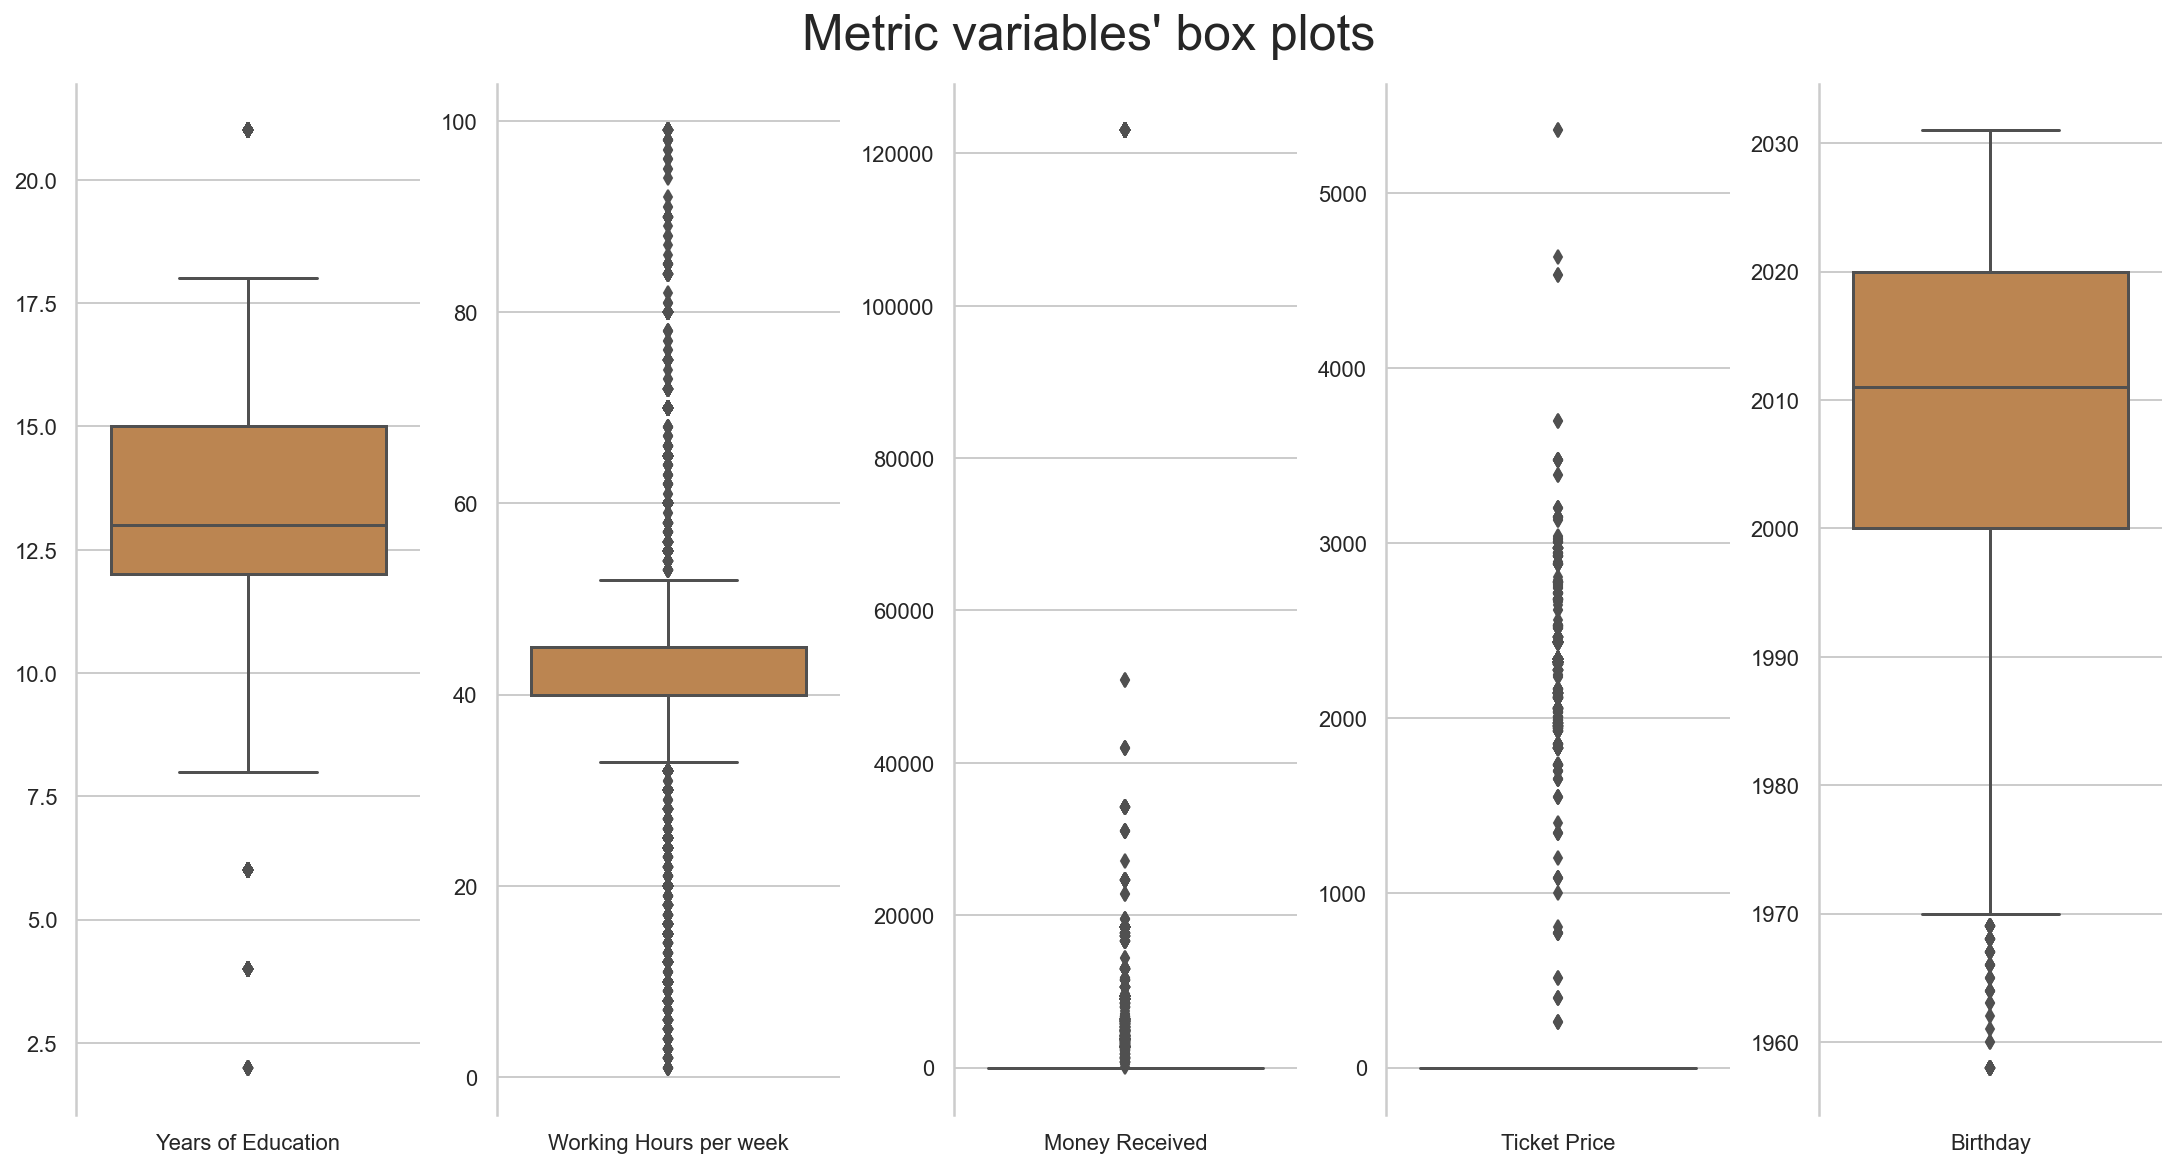

In [106]:
sns.set(style="whitegrid")

data = pd.melt(metric)
plot_features = metric.columns

#Prepare figure layout
fig, axes = plt.subplots(1, len(plot_features), figsize=(15,8), constrained_layout=True)
    
# Draw the boxplots
for i in zip(axes, plot_features):
    sns.boxplot(x="variable", y="value", data=data.loc[data["variable"]==i[1]], ax=i[0], color='peru')
    i[0].set_xlabel("")
    i[0].set_ylabel("")

# Finalize the plot
plt.suptitle("Metric variables' box plots", fontsize=25)
sns.despine(bottom=True)

plt.show()

In [107]:
#test
df_train[df_train["Money Received"]==122999] 

,Name,Birthday,Native Continent,Marital Status,Lives with,Base Area,Education Level,Years of Education,Employment Sector,Role,Working Hours per week,Money Received,Ticket Price
CITIZEN_ID,,,,,,,,,,,,,
12667,Mr. Alexander Duncan,1997-03-17,Oceania,Married,Wife,Sharnwick,Masters + PostGraduation,18,Self-Employed (Individual),Professor,70,122999,0
12839,Mr. Sam Black,1985-05-26,Europe,Married,Wife,Northbury,Professional School,12,Private Sector - Services,Repair & constructions,40,122999,0
13363,Mr. Jason Dickens,2009-01-20,Europe,Married,Wife,Northbury,Masters,17,Private Sector - Services,Professor,40,122999,0
13419,Mr. Harry Parr,1999-09-29,Europe,Married,Wife,Northbury,Masters,17,Private Sector - Others,Sales,80,122999,0
13445,Mr. Jacob Wilson,2008-06-28,Europe,Married,Wife,Northbury,Masters + PostGraduation,18,Self-Employed (Individual),Professor,70,122999,0
13557,Mr. Liam Abraham,1995-05-17,Europe,Married,Wife,Northbury,Professional School,12,Self-Employed (Company),Sales,40,122999,0
13759,Mrs. Lauren Morgan,2012-07-31,Africa,Married,Husband,Northbury,High School + PostGraduation,13,Private Sector - Services,Administratives,40,122999,0
13809,Mr. Jack Kerr,2008-05-23,Asia,Married,Wife,NaN,Masters + PostGraduation,18,Private Sector - Services,Professor,40,122999,0
14070,Mr. Joseph Buckland,1992-07-20,Europe,Married,Wife,Northbury,Masters + PostGraduation,18,Self-Employed (Company),Professor,40,122999,0


In [108]:
df_train["Working Hours per week"].describe()

count    22400.000000
mean        40.456696
std         12.414943
min          0.000000
25%         40.000000
50%         40.000000
75%         45.000000
max         99.000000
Name: Working Hours per week, dtype: float64

#RECOMENTAR

#using the IQR method to filter outliers: the scatter plot was impossible to analyze with the outliers, and there are some
#very extreme values on 'precoContratual' and, especially, on 'prazoExecucao'

#calculate the first and third quantiles:
q25 = df_train['Working Hours per week'].quantile(.25)
q75 = df_train['Working Hours per week'].quantile(.75)
#calculate the inter-quartile range:
iqr = (q75 - q25)

#calculate the lower and upper fence:
multiplicator = 6 #5 or 6 looks better; with 1.5 (the "official") or 2 you delete too much of the data
upper_lim = q75 + multiplicator * iqr
lower_lim = q25 - multiplicator * iqr

#filtering the outliers based on the IQR limits
df_train_new = df_train[(df_train['Working Hours per week'] > lower_lim) & (df_train['Working Hours per week'] < upper_lim)]
print('Percentage of data kept after removing outliers:', np.round(df_train_new.shape[0] / df_train.shape[0], 4))

We decided not to eliminate outliers on "Money Received", since when observing the value that was more distant from the rest, we concluded that there were several people with that high value (122999), all having a relatively important role and high hours of work. 

Also, we do not consider relevant the amount itself of money received or payed, but instead, if the person received or payed to go. 

sns.set(style="whitegrid")
sns.boxplot(x="Working Hours per week", data=df_train_new, color='peru')
plt.suptitle("Working Hours Without Outliers", fontsize=20)
plt.show()

In [109]:
#number of citizens that have less than 7.5 years of education to conclude if they might be outliers
len(df_train[df_train["Years of Education"]<7.5])

392

In [110]:
#NAO USAMOS

from numpy.random import seed
from numpy.random import randn
from scipy.stats import shapiro

# normality test
stat, p = shapiro(df_train["Working Hours per week"])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.885, p=0.000
Sample does not look Gaussian (reject H0)


/Users/Mariana/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


## Missing Values

#### 1st method - impute with the mode

In [111]:
df_train1=df_train.copy()

In [112]:
modes = non_metric.mode().loc[0]
df_train1.fillna(modes, inplace=True)
df_train1.isna().sum()

Name                      0
Birthday                  0
Native Continent          0
Marital Status            0
Lives with                0
Base Area                 0
Education Level           0
Years of Education        0
Employment Sector         0
Role                      0
Working Hours per week    0
Money Received            0
Ticket Price              0
dtype: int64

#### 2nd method - imupte with the mode of categories in common

In [113]:
# understand if certain non-numeric variables are dependent or not from the ones with missing values

In [116]:
from scipy.stats import chi2_contingency
from scipy.stats import chi2

# Create a function that performs the Chi2 test for independence, to check for association between each variable with no missing
# values and each of the ones with missings

def check_association(col1,col2):
    # contingency table
    tab=pd.crosstab(df_train[col1], df_train[col2], margins=False).values
    stat, p, dof, expected = chi2_contingency(tab)

    # interpret test-statistic
    prob = 0.95
    critical = chi2.ppf(prob, dof)
    print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
    
    if abs(stat) >= critical:
        print(col1,'and',col2,'are dependent (reject H0).')
    else:
        print(col1,'and',col2,'are independent (fail to reject H0).')
        
    # interpret p-value
    alpha = 1.0 - prob
    print('significance=%.3f, p=%.3f' % (alpha, p))
    
    if p <= alpha:
        print(col1,'and',col2,'are dependent (reject H0).\n')
    else:
        print(col1,'and',col2,'are independent (fail to reject H0).\n')

In [117]:
# FIRST: Marital Status

check_association('Marital Status','Base Area')
check_association('Marital Status','Employment Sector')
check_association('Marital Status','Role')

probability=0.950, critical=264.224, stat=707.714
Marital Status and Base Area are dependent (reject H0).
significance=0.050, p=0.000
Marital Status and Base Area are dependent (reject H0).

probability=0.950, critical=58.124, stat=798.754
Marital Status and Employment Sector are dependent (reject H0).
significance=0.050, p=0.000
Marital Status and Employment Sector are dependent (reject H0).

probability=0.950, critical=106.395, stat=2136.649
Marital Status and Role are dependent (reject H0).
significance=0.050, p=0.000
Marital Status and Role are dependent (reject H0).



In [118]:
# SECOND: Education Level

check_association('Education Level','Base Area')
check_association('Education Level','Employment Sector')
check_association('Education Level','Role')

probability=0.950, critical=626.650, stat=6057.678
Education Level and Base Area are dependent (reject H0).
significance=0.050, p=0.000
Education Level and Base Area are dependent (reject H0).

probability=0.950, critical=129.918, stat=1544.322
Education Level and Employment Sector are dependent (reject H0).
significance=0.050, p=0.000
Education Level and Employment Sector are dependent (reject H0).

probability=0.950, critical=244.808, stat=10712.853
Education Level and Role are dependent (reject H0).
significance=0.050, p=0.000
Education Level and Role are dependent (reject H0).



In [119]:
# Seeing both of these variables are associated with the three variables with missing values, using the similarities between people
# in these categories, might be useful to discover their characteristics in the missing variables

In [123]:
# Copy the dataframe into another to apply the changes there before
df_train2=df_train.copy()

# Create a function to impute the missing values by the mode of the records belonging to the same classes of Marital Status and Education Level
def impute_mode_by_cat(col):
    exp=df_train2[df_train2[col].isnull()].reset_index()
    gr=df_train2.groupby(["Education Level","Marital Status"])[col].agg(pd.Series.mode)
    
    # if there are null values in the group by, replace them by the overall mode of the orginal variable
    for i in range(len(gr)):
        if len(gr[i])==0:
            gr[i]=df_train2[col].mode()[0]


    # define the values of base area in the new auxiliary dataset as the mode of the base are values for the observations with the
    # same level of education and marital status, because at least to some extent, they are more similar than the others       
    for i in range(len(exp)):
        for x in range(len(gr)):
            if (exp['Education Level'][i]==gr.index[x][0]) and (exp['Marital Status'][i]==gr.index[x][1]):
                exp[col][i]=gr[x]
                
    # if it's bimodal (has more than one mode, keep only the first one provided)
    for i in range(len(exp)):
        if type(exp[col][i])!=str:
            exp[col][i]=df_train2[col].mode()[0]

    # finally, replace the null values in Base Area in the original dataset by the values acquired before
    for i in range(len(exp)):
        df_train2.loc[exp['CITIZEN_ID'][i],col]=exp[col][i]
        
    return df_train2

In [124]:
df_train2[df_train2['Base Area'].isnull()]

,Name,Birthday,Native Continent,Marital Status,Lives with,Base Area,Education Level,Years of Education,Employment Sector,Role,Working Hours per week,Money Received,Ticket Price
CITIZEN_ID,,,,,,,,,,,,,
12516,Mr. Jason Gray,2024-09-26,Africa,Single,Other Family,NaN,Bachelors,15,Private Sector - Services,Sales,40,0,0
12583,Mr. Joseph Avery,2008-09-06,Europe,Married,Wife,NaN,Bachelors + PostGraduation,16,Self-Employed (Company),Sales,40,0,0
12700,Mr. Colin Graham,2017-02-14,Europe,Single,Other relatives,NaN,Bachelors + PostGraduation,16,Public Sector - Others,Professor,40,0,0
12771,Mrs. Emma Gray,2005-02-22,Europe,Married - Spouse Missing,Other Family,NaN,PhD,21,Private Sector - Services,Professor,40,0,0
12845,Mr. Alexander Rampling,2022-02-28,Africa,Single,Other Family,NaN,Bachelors + PostGraduation,16,Private Sector - Services,Management,50,0,0
12875,Mr. Owen Scott,2027-07-20,Europe,Single,Children,NaN,High School + PostGraduation,13,Private Sector - Services,Machine Operators & Inspectors,40,0,0
12891,Mr. Anthony McDonald,2020-10-06,Europe,Single,Other Family,NaN,High School - 2nd Cycle,11,Private Sector - Services,Repair & constructions,40,0,0
12895,Mrs. Bella Hemmings,1991-05-07,Europe,Widow,Alone,NaN,Professional School,12,Private Sector - Services,Other services,30,0,0
12956,Mr. William Wilson,2004-05-20,Europe,Married,Wife,NaN,Professional School,12,Self-Employed (Company),Transports,60,0,0


In [125]:
df_train2=impute_mode_by_cat('Base Area')

<ipython-input-123-79cd64ba2945>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp[col][i]=gr[x]
<ipython-input-123-79cd64ba2945>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp[col][i]=df_train2[col].mode()[0]


In [126]:
df_train2[df_train2['Employment Sector'].isnull()]

,Name,Birthday,Native Continent,Marital Status,Lives with,Base Area,Education Level,Years of Education,Employment Sector,Role,Working Hours per week,Money Received,Ticket Price
CITIZEN_ID,,,,,,,,,,,,,
12508,Miss Gabrielle Cameron,2028-02-09,Europe,Single,Other relatives,Northbury,Professional School,12,NaN,NaN,35,0,0
12511,Miss Amy Churchill,2029-02-10,Europe,Single,Children,Northbury,High School + PostGraduation,13,NaN,NaN,40,0,0
12523,Mr. William Sanderson,1997-10-08,Europe,Married,Wife,Northbury,Masters,17,NaN,NaN,40,0,0
12529,Miss Deirdre Lyman,2018-03-28,Asia,Single,Other Family,Knife's Edge,Bachelors + PostGraduation,16,NaN,NaN,50,0,0
12530,Mrs. Carolyn Tucker,1976-02-03,Europe,Widow,Other Family,Northbury,High School - 2nd Cycle,11,NaN,NaN,24,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34795,Mr. Luke Smith,1985-03-05,Europe,Married,Wife,Northbury,Professional School,12,NaN,NaN,20,0,0
34814,Mr. Stewart Newman,1990-01-23,America,Married - Spouse Missing,Alone,Northbury,Primary School,4,NaN,NaN,40,0,0
34823,Mr. Jonathan Slater,2006-05-27,Europe,Married,Wife,Northbury,High School + PostGraduation,13,NaN,NaN,60,0,0


In [127]:
df_train2=impute_mode_by_cat('Employment Sector')

<ipython-input-123-79cd64ba2945>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp[col][i]=gr[x]
<ipython-input-123-79cd64ba2945>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp[col][i]=df_train2[col].mode()[0]


In [128]:
df_train2[df_train2['Role'].isnull()]

,Name,Birthday,Native Continent,Marital Status,Lives with,Base Area,Education Level,Years of Education,Employment Sector,Role,Working Hours per week,Money Received,Ticket Price
CITIZEN_ID,,,,,,,,,,,,,
12508,Miss Gabrielle Cameron,2028-02-09,Europe,Single,Other relatives,Northbury,Professional School,12,Private Sector - Services,NaN,35,0,0
12511,Miss Amy Churchill,2029-02-10,Europe,Single,Children,Northbury,High School + PostGraduation,13,Private Sector - Services,NaN,40,0,0
12523,Mr. William Sanderson,1997-10-08,Europe,Married,Wife,Northbury,Masters,17,Private Sector - Services,NaN,40,0,0
12529,Miss Deirdre Lyman,2018-03-28,Asia,Single,Other Family,Knife's Edge,Bachelors + PostGraduation,16,Private Sector - Services,NaN,50,0,0
12530,Mrs. Carolyn Tucker,1976-02-03,Europe,Widow,Other Family,Northbury,High School - 2nd Cycle,11,Private Sector - Services,NaN,24,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34795,Mr. Luke Smith,1985-03-05,Europe,Married,Wife,Northbury,Professional School,12,Private Sector - Services,NaN,20,0,0
34814,Mr. Stewart Newman,1990-01-23,America,Married - Spouse Missing,Alone,Northbury,Primary School,4,Private Sector - Services,NaN,40,0,0
34823,Mr. Jonathan Slater,2006-05-27,Europe,Married,Wife,Northbury,High School + PostGraduation,13,Private Sector - Services,NaN,60,0,0


In [129]:
df_train2=impute_mode_by_cat('Role')

<ipython-input-123-79cd64ba2945>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp[col][i]=gr[x]
<ipython-input-123-79cd64ba2945>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp[col][i]=df_train2[col].mode()[0]


In [130]:
df_train2.isna().sum()

Name                      0
Birthday                  0
Native Continent          0
Marital Status            0
Lives with                0
Base Area                 0
Education Level           0
Years of Education        0
Employment Sector         0
Role                      0
Working Hours per week    0
Money Received            0
Ticket Price              0
dtype: int64

/Users/Mariana/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/Mariana/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/Mariana/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warn

Text(0.5, 0.98, 'Distribution of variables with and without missing values')

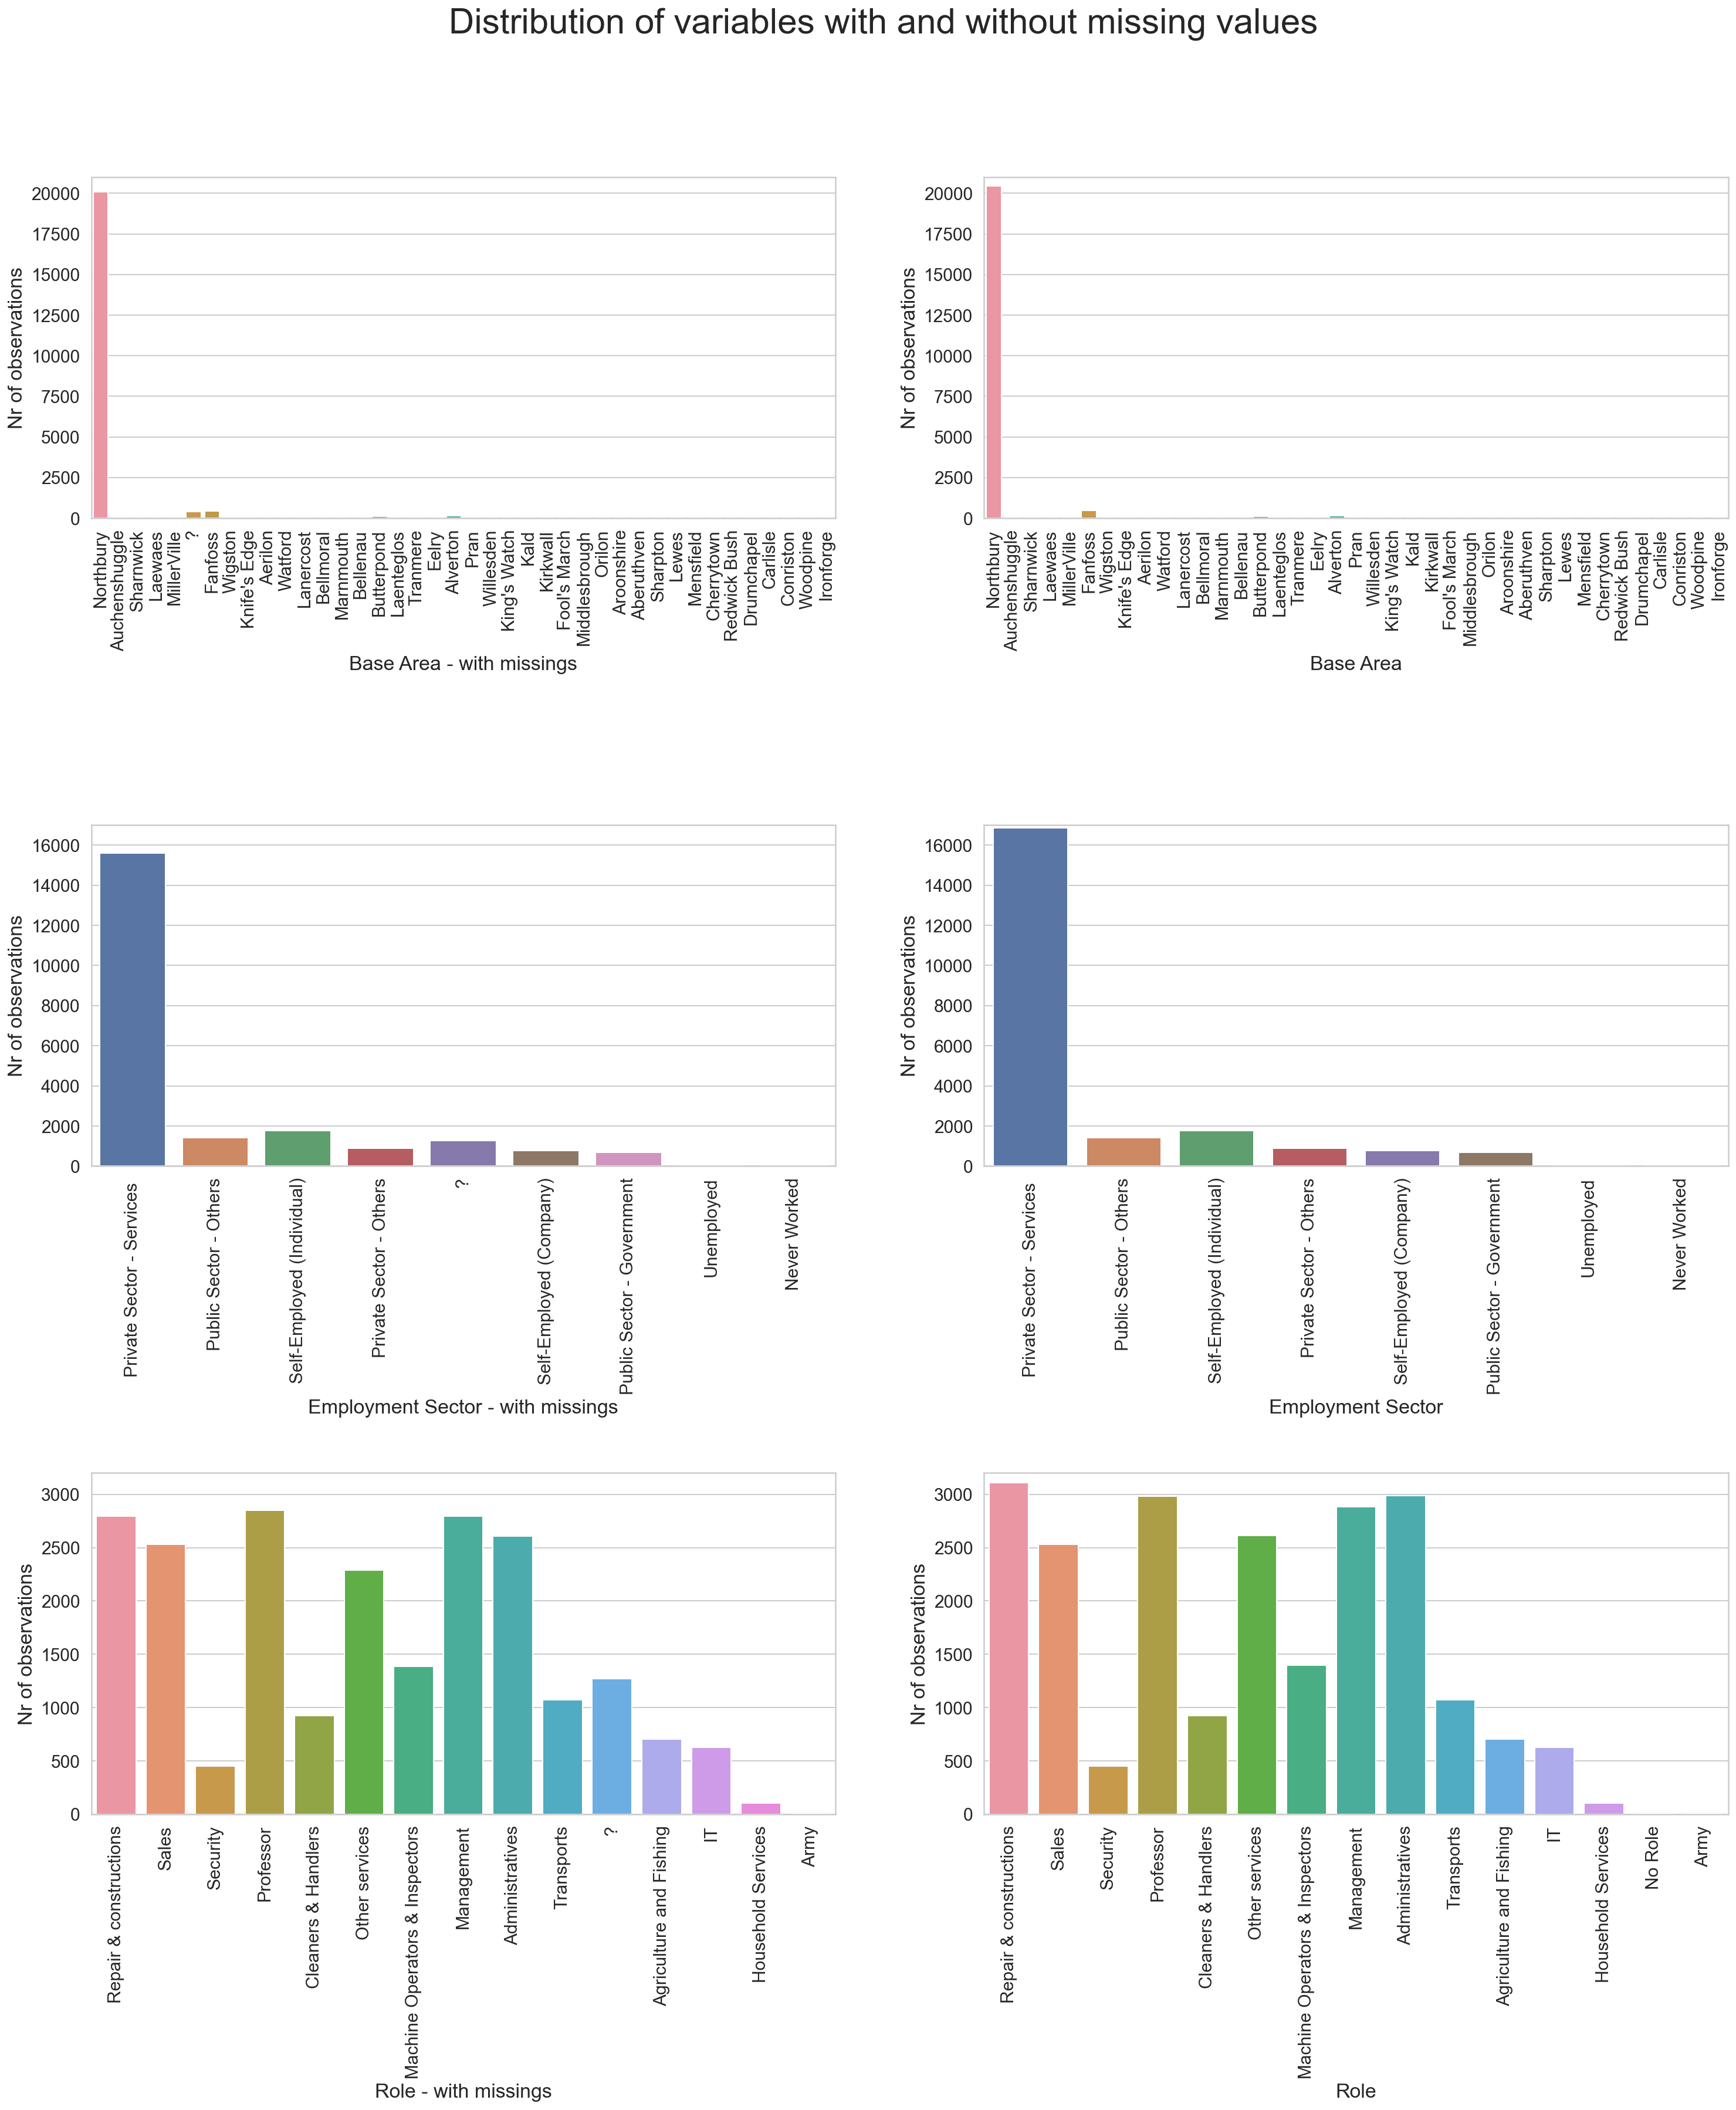

In [131]:
# Funciona
sns.set_style("whitegrid")
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(25,25))


axa=sns.countplot(df_train2["Base Area"], ax=axes[0,1])
axb=sns.countplot(df_train2["Employment Sector"], ax=axes[1,1])
axc=sns.countplot(df_train2["Role"], ax=axes[2,1])

ax4=sns.countplot(non_metric["Base Area"], ax=axes[0,0])
ax5=sns.countplot(non_metric["Employment Sector"], ax=axes[1,0])
ax7=sns.countplot(non_metric["Role"], ax=axes[2, 0])


axa.tick_params(labelsize=15)
axa.set_xticklabels(axa.get_xticklabels(), rotation=90)
axa.set_xlabel(xlabel='Base Area',fontsize = 17)
axa.set_ylabel(ylabel='Nr of observations',fontsize = 17)
axa.set(ylim=(0, 21000))

ax4.tick_params(labelsize=15)
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=90)
ax4.set_xlabel(xlabel='Base Area - with missings',fontsize = 17)
ax4.set_ylabel(ylabel='Nr of observations',fontsize = 17)
ax4.set(ylim=(0, 21000))

axb.tick_params(labelsize=15)
axb.set_xticklabels(axb.get_xticklabels(), rotation=90)
axb.set_xlabel(xlabel='Employment Sector',fontsize = 17)
axb.set_ylabel(ylabel='Nr of observations',fontsize = 17)
axb.set(ylim=(0, 17000))

ax5.tick_params(labelsize=15)
ax5.set_xticklabels(ax5.get_xticklabels(), rotation=90)
ax5.set_xlabel(xlabel='Employment Sector - with missings',fontsize = 17)
ax5.set_ylabel(ylabel='Nr of observations',fontsize = 17)
ax5.set(ylim=(0, 17000))

axc.tick_params(labelsize=15)
axc.set_xticklabels(axc.get_xticklabels(), rotation=90)
axc.set_xlabel(xlabel='Role',fontsize = 17)
axc.set_ylabel(ylabel='Nr of observations',fontsize = 17)
axc.set(ylim=(0, 3200))

ax7.tick_params(labelsize=15)
ax7.set_xticklabels(ax7.get_xticklabels(), rotation=90)
ax7.set_xlabel(xlabel='Role - with missings',fontsize = 17)
ax7.set_ylabel(ylabel='Nr of observations',fontsize = 17)
ax7.set(ylim=(0, 3200))

plt.subplots_adjust(top=0.9,hspace=0.9)
plt.suptitle("Distribution of variables with and without missing values", fontsize=30)

## Feature Engineering

In [167]:
#EXPLICARRR

# New variable for Age
from datetime import datetime
df_train2["Age"]=df_train2.Birthday.map(lambda x: datetime.now().year+28-x.year)

In [169]:
df_train2[["Birthday","Age"]]

,Birthday,Age
CITIZEN_ID,,
12486,2003-07-01,45
12487,2006-01-25,42
12488,2009-05-10,39
12489,1985-03-25,63
12490,2015-05-29,33
...,...,...
34881,2023-03-15,25
34882,2025-03-07,23
34883,2022-07-20,26


In [133]:
# New variable for Gender - binary if it's a male or not
df_train2['Male'] = np.where(df_train2.Name.str.contains('Mrs|Miss'), '0', '1')

In [134]:
# Check the values for variable Marital Status
df_train2["Marital Status"].unique()

array(['Married', 'Single', 'Married - Spouse Missing', 'Divorced',
       'Separated', 'Widow', 'Married - Spouse in the Army'], dtype=object)

In [135]:
#In column Marital Status, join "Married" with 'Married - Spouse Missing' and 'Married - Spouse in the Army' since we do not consider this distintion relevant
df_train2["Marital Status_new"]=df_train2["Marital Status"]
df_train2["Marital Status_new"][(df_train2["Marital Status"].str.contains("Married")==True) & (df_train2["Marital Status"]!="Married")]="Married"

#In column Marital Status, join "Divorced" with 'Separated' in "Divorced or Separated"
df_train2["Marital Status_new"][(df_train2["Marital Status"]=="Separated") | (df_train2["Marital Status"]=="Divorced")]="Divorced or Separated"

df_train2["Marital Status_new"][(df_train2["Marital Status"]=="Married")]

<ipython-input-135-d3808c6b0aad>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train2["Marital Status_new"][(df_train2["Marital Status"].str.contains("Married")==True) & (df_train2["Marital Status"]!="Married")]="Married"
<ipython-input-135-d3808c6b0aad>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train2["Marital Status_new"][(df_train2["Marital Status"]=="Separated") | (df_train2["Marital Status"]=="Divorced")]="Divorced or Separated"


CITIZEN_ID
12486    Married
12487    Married
12488    Married
12489    Married
12492    Married
          ...   
34876    Married
34877    Married
34878    Married
34879    Married
34880    Married
Name: Marital Status_new, Length: 10219, dtype: object

In [136]:
# New binary variable to determine whether the person is married
df_train2["Is Married"]=0
df_train2["Is Married"][(df_train2["Marital Status_new"]=="Married")]=1

<ipython-input-136-6b0578b734da>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train2["Is Married"][(df_train2["Marital Status_new"]=="Married")]=1


In [137]:
df_train2["Marital Status_new"].unique()

array(['Married', 'Single', 'Divorced or Separated', 'Widow'],
      dtype=object)

In [138]:
df_train2["Is Married"]

CITIZEN_ID
12486    1
12487    1
12488    1
12489    1
12490    0
        ..
34881    0
34882    0
34883    0
34884    0
34885    0
Name: Is Married, Length: 22400, dtype: int64

In [139]:
# Check the values for variable Education Level
df_train2["Education Level"].unique()

array(['High School + PostGraduation', 'Professional School',
       'High School - 2nd Cycle', 'PhD', 'Bachelors',
       'Bachelors + PostGraduation', 'Masters', 'High School - 1st Cycle',
       'High School Complete', 'Masters + PostGraduation',
       'Professional School + PostGraduation',
       'Middle School - 2nd Cycle', 'Middle School Complete',
       'Middle School - 1st Cycle', 'Primary School',
       'No Relevant Education'], dtype=object)

In [140]:
#In column Education Level, join all equal periods of education level

df_train2["Education Level_new"]=df_train2["Education Level"]

df_train2["Education Level_new"][(df_train2["Education Level"]=="Middle School - 1st Cycle") |
                    (df_train2["Education Level"]=="Middle School - 2nd Cycle")|
                    (df_train2["Education Level"]=="Middle School Complete")]="Middle School"

df_train2["Education Level_new"][(df_train2["Education Level"]=="High School - 1st Cycle") | 
                    (df_train2["Education Level"]=="High School - 2nd Cycle") | 
                    (df_train2["Education Level"]=="High School Complete")]="High School"

<ipython-input-140-949cf134105c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train2["Education Level_new"][(df_train2["Education Level"]=="Middle School - 1st Cycle") |
<ipython-input-140-949cf134105c>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train2["Education Level_new"][(df_train2["Education Level"]=="High School - 1st Cycle") |


In [141]:
df_train2["Education Level_new"].unique()

array(['High School + PostGraduation', 'Professional School',
       'High School', 'PhD', 'Bachelors', 'Bachelors + PostGraduation',
       'Masters', 'Masters + PostGraduation',
       'Professional School + PostGraduation', 'Middle School',
       'Primary School', 'No Relevant Education'], dtype=object)

In [142]:
df_train2["Years of Education"][df_train2["Education Level_new"]=='Professional School'].unique()

array([12])

In [143]:
df_train2["Years of Education"][df_train2["Education Level_new"]=='High School']

CITIZEN_ID
12489    11
12493    11
12505    10
12512    12
12524    11
         ..
34847    11
34856    10
34857    12
34858    10
34865    11
Name: Years of Education, Length: 1745, dtype: int64

In [144]:
#Join all without considering Post Graduation

df_train2["Education Level_new2"]=df_train2["Education Level_new"].copy()
df_train2["Education Level_new2"][(df_train2["Education Level_new2"]=="High School + PostGraduation")]="High School"
df_train2["Education Level_new2"][(df_train2["Education Level_new2"]=="Bachelors + PostGraduation")]="Bachelors"
df_train2["Education Level_new2"][(df_train2["Education Level_new2"]=="Professional School + PostGraduation")]="Professional School"
df_train2["Education Level_new2"][(df_train2["Education Level_new2"]=="Masters + PostGraduation")]="Masters"
df_train2[["Education Level_new", "Education Level_new2"]]

<ipython-input-144-4d90ae3416be>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train2["Education Level_new2"][(df_train2["Education Level_new2"]=="High School + PostGraduation")]="High School"
<ipython-input-144-4d90ae3416be>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train2["Education Level_new2"][(df_train2["Education Level_new2"]=="Bachelors + PostGraduation")]="Bachelors"
<ipython-input-144-4d90ae3416be>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

,Education Level_new,Education Level_new2
CITIZEN_ID,,
12486,High School + PostGraduation,High School
12487,Professional School,Professional School
12488,Professional School,Professional School
12489,High School,High School
12490,PhD,PhD
...,...,...
34881,Professional School,Professional School
34882,Professional School,Professional School
34883,Masters,Masters


In [145]:
#Binary that says if the citizen has Post Graduation or not

df_train2["PostGraduation"]=df_train2["Education Level_new"].map(lambda x: 1 if "+" in x else 0)
df_train2["PostGraduation"]

CITIZEN_ID
12486    1
12487    0
12488    0
12489    0
12490    0
        ..
34881    0
34882    0
34883    0
34884    1
34885    1
Name: PostGraduation, Length: 22400, dtype: int64

In [146]:
# New binary variable related to Higher Education
# (includes at least one of the following: Post Graduation, Bachelors, Masters, PhD)

df_train2['Higher Education']=np.where(df_train2['Years of Education']>12, '1', '0')

In [147]:
# New binary variable that tells us if each person lives in the capital city or not
df_train2['Capital']= np.where(df_train2['Base Area']=='Northbury', '1', '0')

In [148]:
# New binary variable to determine whether the person belongs to Group B (people who were payed to participate in the mission)
df_train2['Group B']=np.where(df_train2['Money Received']!=0, '1', '0')

In [149]:
# New binary variable to determine whether the person belongs to Group C (people who payed to participate in the mission)
df_train2['Group C']=np.where(df_train2['Ticket Price']!=0, '1', '0')

In [150]:
df_train2.head()

,Name,Birthday,Native Continent,Marital Status,Lives with,Base Area,Education Level,Years of Education,Employment Sector,Role,...,Male,Marital Status_new,Is Married,Education Level_new,Education Level_new2,PostGraduation,Higher Education,Capital,Group B,Group C
CITIZEN_ID,,,,,,,,,,,,,,,,,,,,,
12486,Mr. Adam Glover,2003-07-01,Europe,Married,Wife,Northbury,High School + PostGraduation,13,Private Sector - Services,Repair & constructions,...,1,Married,1,High School + PostGraduation,High School,1,1,1,0,1
12487,Mr. Cameron McDonald,2006-01-25,Europe,Married,Wife,Northbury,Professional School,12,Public Sector - Others,Repair & constructions,...,1,Married,1,Professional School,Professional School,0,0,1,0,0
12488,Mr. Keith Davidson,2009-05-10,Europe,Married,Wife,Northbury,Professional School,12,Private Sector - Services,Sales,...,1,Married,1,Professional School,Professional School,0,0,1,0,1
12489,Mr. Alexander Gill,1985-03-25,Europe,Married,Wife,Northbury,High School - 2nd Cycle,11,Private Sector - Services,Security,...,1,Married,1,High School,High School,0,0,1,1,0
12490,Mr. Neil Piper,2015-05-29,Europe,Single,Other Family,Northbury,PhD,21,Self-Employed (Individual),Professor,...,1,Single,0,PhD,PhD,0,1,1,0,0


In [151]:
# publico ou privado ou self ou uneployed empl. sector
def sectors(a):
    if 'Private Sector' in a:
        return 'Private Sector'
    elif 'Public Sector' in a:
        return 'Public Sector'
    elif 'Self-Employed' in a:
        return 'Self-Employed'
    else:
        return 'Unemployed / Never Worked'
    
df_train2['Employment Sector (simplified)'] = df_train2['Employment Sector'].map(sectors)

In [152]:
# binaria governo ou n empl. sector
df_train2['Government'] = df_train2['Employment Sector'].map(lambda x: 1 if 'Government' in x else 0)

In [153]:
df_train2.columns

Index(['Name', 'Birthday', 'Native Continent', 'Marital Status', 'Lives with',
       'Base Area', 'Education Level', 'Years of Education',
       'Employment Sector', 'Role', 'Working Hours per week', 'Money Received',
       'Ticket Price', 'Age', 'Male', 'Marital Status_new', 'Is Married',
       'Education Level_new', 'Education Level_new2', 'PostGraduation',
       'Higher Education', 'Capital', 'Group B', 'Group C',
       'Employment Sector (simplified)', 'Government'],
      dtype='object')

In [154]:
from sklearn import preprocessing

x = df_train2[["Ticket Price", "Money Received"]].values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df= pd.DataFrame(x_scaled)

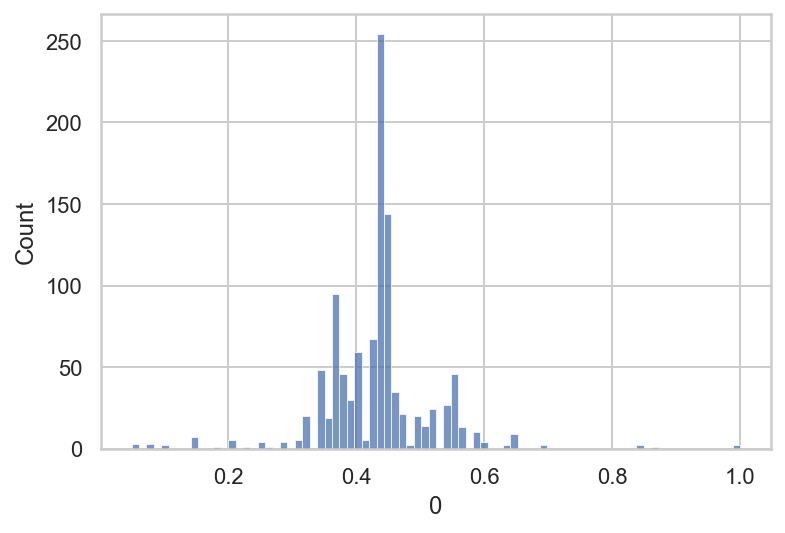

In [155]:
sns.histplot(df[0][df[0]!=0])

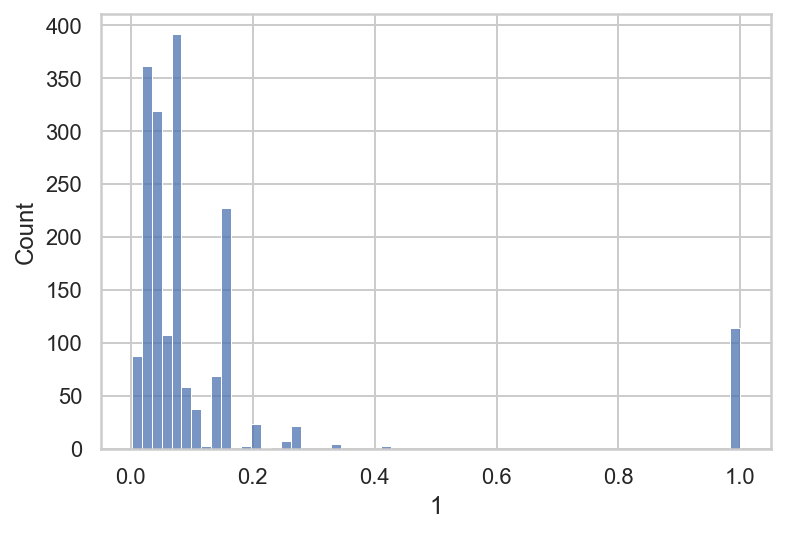

In [156]:
sns.histplot(df[1][df[1]!=0])

In [157]:
Median_Money_Received=df_train2["Money Received"][df_train2["Money Received"]>0].median()
Median_Ticket_Price=df_train2["Ticket Price"][df_train2["Ticket Price"]>0].median()

df_train2['Money Relevance']=0
df_train2['Money Relevance'][df_train2["Money Received"]> Median_Money_Received] =1
df_train2['Money Relevance'][(df_train2["Money Received"]<= Median_Money_Received) & (df_train2["Money Received"]>0)]=2

df_train2['Money Relevance'][df_train2["Ticket Price"]> Median_Ticket_Price] =5
df_train2['Money Relevance'][(df_train2["Ticket Price"]<= Median_Ticket_Price) & (df_train2["Ticket Price"]>0)] =4

df_train2['Money Relevance'][(df_train2["Ticket Price"]== 0) & (df_train2["Money Received"]==0)] =3

<ipython-input-157-2b30f458841b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train2['Money Relevance'][df_train2["Money Received"]> Median_Money_Received] =1
<ipython-input-157-2b30f458841b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train2['Money Relevance'][(df_train2["Money Received"]<= Median_Money_Received) & (df_train2["Money Received"]>0)]=2
<ipython-input-157-2b30f458841b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

In [158]:
df_train2[["Ticket Price", "Money Received", "Money Relevance"]]

,Ticket Price,Money Received,Money Relevance
CITIZEN_ID,,,
12486,2273,0,4
12487,0,0,3
12488,2321,0,4
12489,0,5395,2
12490,0,0,3
...,...,...,...
34881,0,0,3
34882,0,0,3
34883,0,2674,2


In [159]:
#df_train2.drop(columns=["Ticket Price", "Money Received"]), inplace=True)

## Feature Selection

In [170]:
df_train2

,Name,Birthday,Native Continent,Marital Status,Lives with,Base Area,Education Level,Years of Education,Employment Sector,Role,...,Education Level_new,Education Level_new2,PostGraduation,Higher Education,Capital,Group B,Group C,Employment Sector (simplified),Government,Money Relevance
CITIZEN_ID,,,,,,,,,,,,,,,,,,,,,
12486,Mr. Adam Glover,2003-07-01,Europe,Married,Wife,Northbury,High School + PostGraduation,13,Private Sector - Services,Repair & constructions,...,High School + PostGraduation,High School,1,1,1,0,1,Private Sector,0,4
12487,Mr. Cameron McDonald,2006-01-25,Europe,Married,Wife,Northbury,Professional School,12,Public Sector - Others,Repair & constructions,...,Professional School,Professional School,0,0,1,0,0,Public Sector,0,3
12488,Mr. Keith Davidson,2009-05-10,Europe,Married,Wife,Northbury,Professional School,12,Private Sector - Services,Sales,...,Professional School,Professional School,0,0,1,0,1,Private Sector,0,4
12489,Mr. Alexander Gill,1985-03-25,Europe,Married,Wife,Northbury,High School - 2nd Cycle,11,Private Sector - Services,Security,...,High School,High School,0,0,1,1,0,Private Sector,0,2
12490,Mr. Neil Piper,2015-05-29,Europe,Single,Other Family,Northbury,PhD,21,Self-Employed (Individual),Professor,...,PhD,PhD,0,1,1,0,0,Self-Employed,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34881,Mrs. Lisa Alsop,2023-03-15,Europe,Divorced,Children,Northbury,Professional School,12,Private Sector - Services,Cleaners & Handlers,...,Professional School,Professional School,0,0,1,0,0,Private Sector,0,3
34882,Mr. Julian Coleman,2025-03-07,Europe,Single,Children,Northbury,Professional School,12,Private Sector - Services,Other services,...,Professional School,Professional School,0,0,1,0,0,Private Sector,0,3
34883,Miss Amelia Walker,2022-07-20,Europe,Single,Other Family,Northbury,Masters,17,Public Sector - Others,Professor,...,Masters,Masters,0,1,1,1,0,Public Sector,0,2


## Data Partition 